# Project Pipeline

Create an environment for the project

i. Download the data
ii. Import the metadata into pandas

iii. Data Exploration 

    age distribution of the disease 
    count base on the part of the body the mole appear
    count base on the form of test 
    count of the cell type
    count base on gender
    count base on location of disease over gender

iv. Preprocess the data by rescaling; since the original dimension of images cannot be handle by Tensrflow.
    converting the color image to cancer type image for proper visualisation of each disease in each group

v. Split the dataset into Target and Feature. 
    feature = all column expect the leison id
    Target = Leison id 

    Feature and Target(original test) is splitted to X-test, X-train, Y-test, Y-train 

vi. Normalization of feature parameter (X-test amd X-train)
    Estimating the mean and std of X_train and X_test inorder to normalised the features
    NB: The Target is not normalised because they are still categorical

vii. Encoding the label (Target)

viii. Extracting the validate dataset from the train dataset

ix. Setting the layer

x. Adding lost function, score function and optimisation algorithms

xi. Data Augmentation (optional)
   The idea is to alter the training data with small transformations to reproduce the variations
    
xii. Fitting the model
    using epochs and batch size

xiii. Evaluating the model 
    checking the testing accuracy and validation accuracy of our model,plot confusion matrix and also check the missclassified images count of each type

    





In [3]:
import seaborn as sns
import pandas as pd
from glob import glob
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D

from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import backend as k
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


In [4]:
base_skin_dir = "asset/Image/"
base_skin_dir

'asset/Image/'

In [6]:
# Assigning the image and labels to a dictionary
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


In [7]:
skin_df = pd.read_csv("asset\Metadata\HAM10000_metadata.csv")

In [8]:
# Creating extra coulmn for better understanding of the column

skin_df['path'] = base_skin_dir + skin_df['image_id'] + '.jpg'
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [11]:
# displayimg the top 5 data
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,asset/Image/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,asset/Image/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,asset/Image/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,asset/Image/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,asset/Image/ISIC_0031633.jpg,Benign keratosis-like lesions,2


#### Data Cleaning 

Determing their number of missing value

Replacing the missing value with the mean of the column

Determine the data types of each column

In [9]:
# Determing their number of missing value

skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [10]:
# Filling the missing value with the mean

skin_df["age"].fillna((skin_df["age"].mean()), inplace= True)

# Converting dtype of age to int32
skin_df['age'] = skin_df['age'].astype('int32')


skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [11]:
# print the data type for each column
print(skin_df.dtypes)

lesion_id        object
image_id         object
dx               object
dx_type          object
age               int32
sex              object
localization     object
path             object
cell_type        object
cell_type_idx      int8
dtype: object


#### Exploratory Data Analysis

<AxesSubplot:>

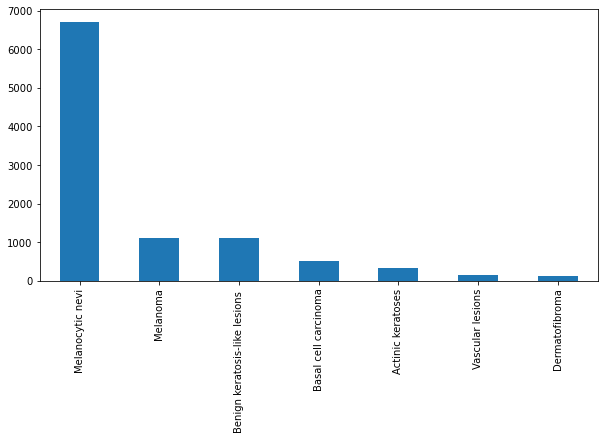

In [12]:
# count of the cell type

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)


<AxesSubplot:>

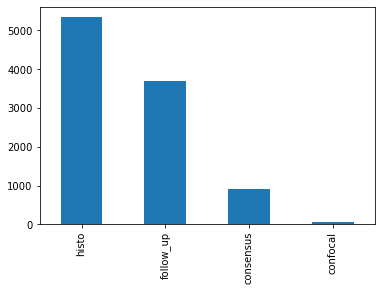

In [13]:
# count base on the form of test 

skin_df['dx_type'].value_counts().plot(kind='bar')

<AxesSubplot:>

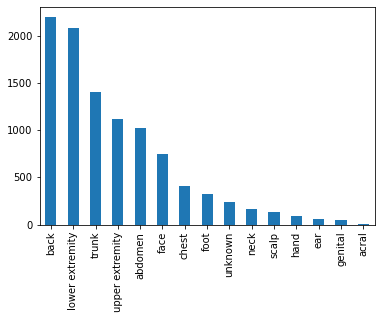

In [14]:
# count base on the part of the body the mole appear


skin_df['localization'].value_counts().plot(kind='bar')

Text(0.5, 1.0, 'Gender of Patient')

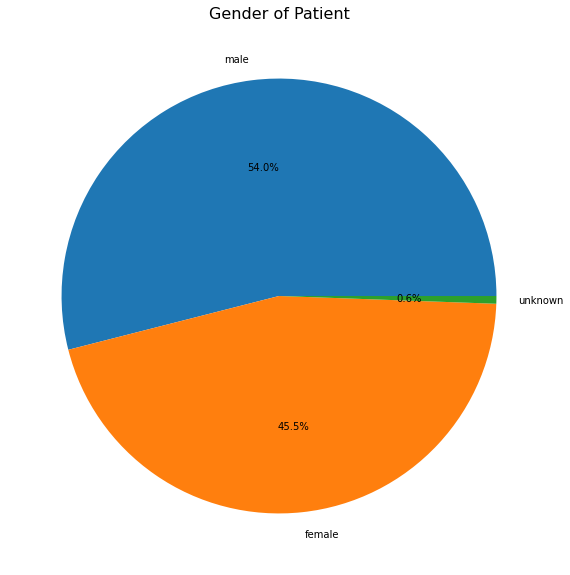

In [15]:
# Gender distribution

bar, ax = plt.subplots(figsize = (10,10))
plt.pie(skin_df['sex'].value_counts(), labels = skin_df['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

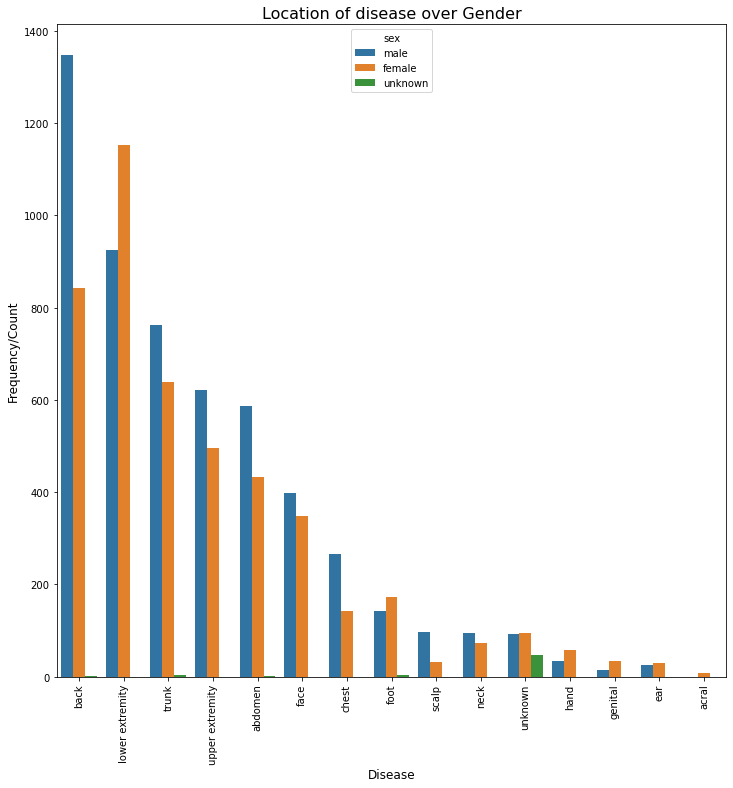

In [16]:
# location of disease over gender 

value = skin_df[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

<AxesSubplot:>

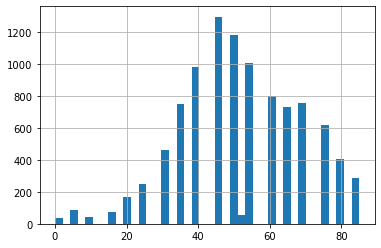

In [17]:
# Age distribution of the disease 

skin_df['age'].hist(bins=40)

##### Resizing the Image 

In [18]:
# Resizing the image so that the TensorFlow can't handle it. 
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))


In [22]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,asset/Image/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,asset/Image/ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,asset/Image/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,asset/Image/ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,asset/Image/ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


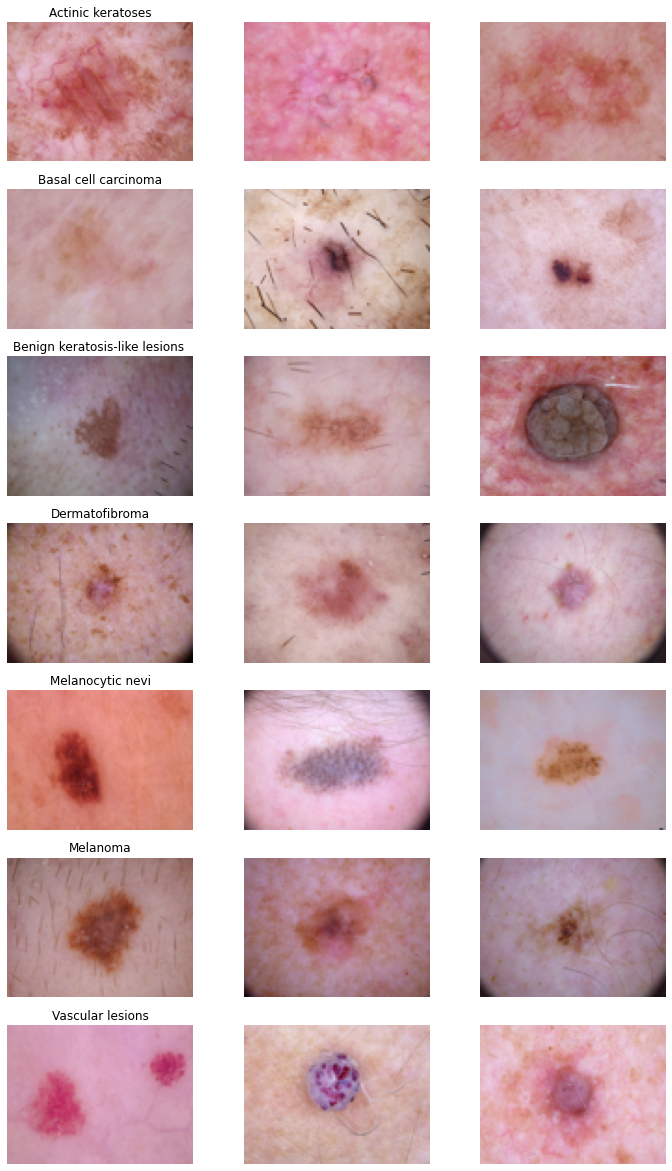

In [19]:
# displaying the image in cancer form instead of color image. 
n_samples = 3
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [20]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

#### Split the dataset 

In [21]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [22]:
#split of the original dataset 

x_train_org, x_test_org, y_train_org, y_test_org = train_test_split(features, target, test_size=0.20,random_state=1)

In [27]:
print('Shape of x_train_org :',x_train_org.shape)
print('Shape of x_test_org :',x_test_org.shape)
print('Shape of y_train_org :',y_train_org.shape)
print('Shape of  y_test_org :',y_test_org.shape)

Shape of x_train_org : (8012, 10)
Shape of x_test_org : (2003, 10)
Shape of y_train_org : (8012,)
Shape of  y_test_org : (2003,)


#### Normalization of the feature parameter (X-test and X-train)


In [23]:
#convert to array
x_train = np.asarray(x_train_org['image'].tolist())             # converting the X_train to num array
x_test = np.asarray(x_test_org['image'].tolist())               # converting the X_test to num array          

# Estimate the mean and std of X-train 

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

# Estimate the mean and std of X-test
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

# Using the calculated mean and std to estimate the normalization

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

#### Encode the catergoical data (Target)


In [24]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_org, num_classes = 7)
y_test = to_categorical(y_test_org, num_classes = 7)

#### Extracting validation dataset from training dataset (x_train and y_train)

In [25]:
# split training(x and y) dataset into validate, x_train and y_train (sound funny right)
# validate data = 10%    and training data = 90% 

x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

#### Reshaping the image to 3 dimension (width, height and canal)

In [26]:
# (height = 75px, width = 100px , canal = 3)    # because the the image was initially resize to 75px X 100px
# (height = 28px, width = 28px , canal = 3)     # because the the image was initially resize to 28px X 28px

x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

##### CNN architechture : Stepwise layers
    In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

In [27]:
# setting up the layer

input_shape = (75, 100, 3)          # (height = 75px, width = 100px , canal = 3)  
num_classes = 7                     # Number of the label

# Set the CNN model 

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 25, 64)        0

In [28]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [29]:
# Compile the model (using optimizer =Adam)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [30]:
# With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half 
#if the accuracy is not improved after 3 epochs.

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [31]:
# With data augmentation to prevent overfitting (maininly on the train  dataset)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

#For the data augmentation, i choosed to : Randomly rotate some training images by 10 degrees Randomly Zoom
#  by 10% some training images Randomly shift images horizontally by 10% of the width Randomly shift images 
# vertically by 10% of the height Once our model is ready

##### Fitting the model

In [32]:
# Fit the model
epochs = 25
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
721/721 [==============================] - 148s 206ms/step - loss: 0.9968 - accuracy: 0.6663 - val_loss: 0.8829 - val_accuracy: 0.6671
Epoch 2/25
721/721 [==============================] - 151s 210ms/step - loss: 0.9048 - accuracy: 0.6739 - val_loss: 0.8375 - val_accuracy: 0.6820
Epoch 3/25
721/721 [==============================] - 161s 223ms/step - loss: 0.8704 - accuracy: 0.6824 - val_loss: 0.8491 - val_accuracy: 0.7020
Epoch 4/25
721/721 [==============================] - 154s 214ms/step - loss: 0.8527 - accuracy: 0.6911 - val_loss: 0.7949 - val_accuracy: 0.7070
Epoch 5/25
721/721 [==============================] - 156s 216ms/step - loss: 0.8307 - accuracy: 0.6914 - val_loss: 0.7901 - val_accuracy: 0.7007
Epoch 6/25
721/721 [==============================] - 157s 217ms/step - loss: 0.8134 - accuracy: 0.6965 - val_loss: 0.8071 - val_accuracy: 0.7219
Epoch 7/25
721/721 [============================

In [33]:
model.save('model2.h5')

#### Model Evaluation 

In [34]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy_v = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))


26/26 [==============================] - 6s 224ms/step - loss: 0.6848 - accuracy: 0.7481
Validation: accuracy_v = 0.748130  ;  loss_v = 0.684848
Test: accuracy = 0.751872  ;  loss = 0.691553


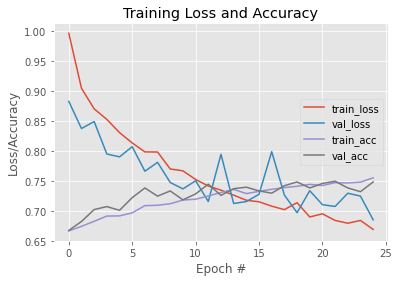

In [36]:
# plot the training loss and accuracy
N = 25sn
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")